In [1]:
options(repr.plot.width = 24, repr.plot.height = 16)

library(ape)
library(ggtree)
library(ggplot2)
library(dplyr)
library(readr)
library(tidyr)
library(ggmsa)
library(Biostrings)
library(patchwork)


tree <- read.tree(
  "~/workspace/genome_data/annotations/s_aureus/gene_sequences/essC/sample/tree.nwk"
)

mortality_df <- read_csv(
  "~/workspace/ehr_data/data/full_cohort/tube_id_mortality_labels.csv"
)

pos_tree = keep.tip(tree, mortality_df %>% filter(death_7_day == 1) %>% pull(tube_code) %>% intersect(tree$tip.label))
neg_tree = keep.tip(tree, mortality_df %>% filter(death_7_day == 0) %>% pull(tube_code) %>% intersect(tree$tip.label))

combined_tree <- bind.tree(pos_tree, neg_tree, where = "root")

ggtree v3.16.0 Learn more at https://yulab-smu.top/contribution-tree-data/

Please cite:

S Xu, Z Dai, P Guo, X Fu, S Liu, L Zhou, W Tang, T Feng, M Chen, L
Zhan, T Wu, E Hu, Y Jiang, X Bo, G Yu. ggtreeExtra: Compact
visualization of richly annotated phylogenetic data. Molecular Biology
and Evolution. 2021, 38(9):4039-4042. doi: 10.1093/molbev/msab166


Attaching package: ‘ggtree’


The following object is masked from ‘package:ape’:

    rotate



Attaching package: ‘dplyr’


The following object is masked from ‘package:ape’:

    where


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following object is masked from ‘package:ggtree’:

    expand


Registered S3 methods overwritten by 'ggalt':
  method                  from   
  grid.draw.absoluteGrob  ggplot2
  grobHeight.absoluteGrob ggplot2
  grobWidth.absoluteGrob  ggplot2
  gr

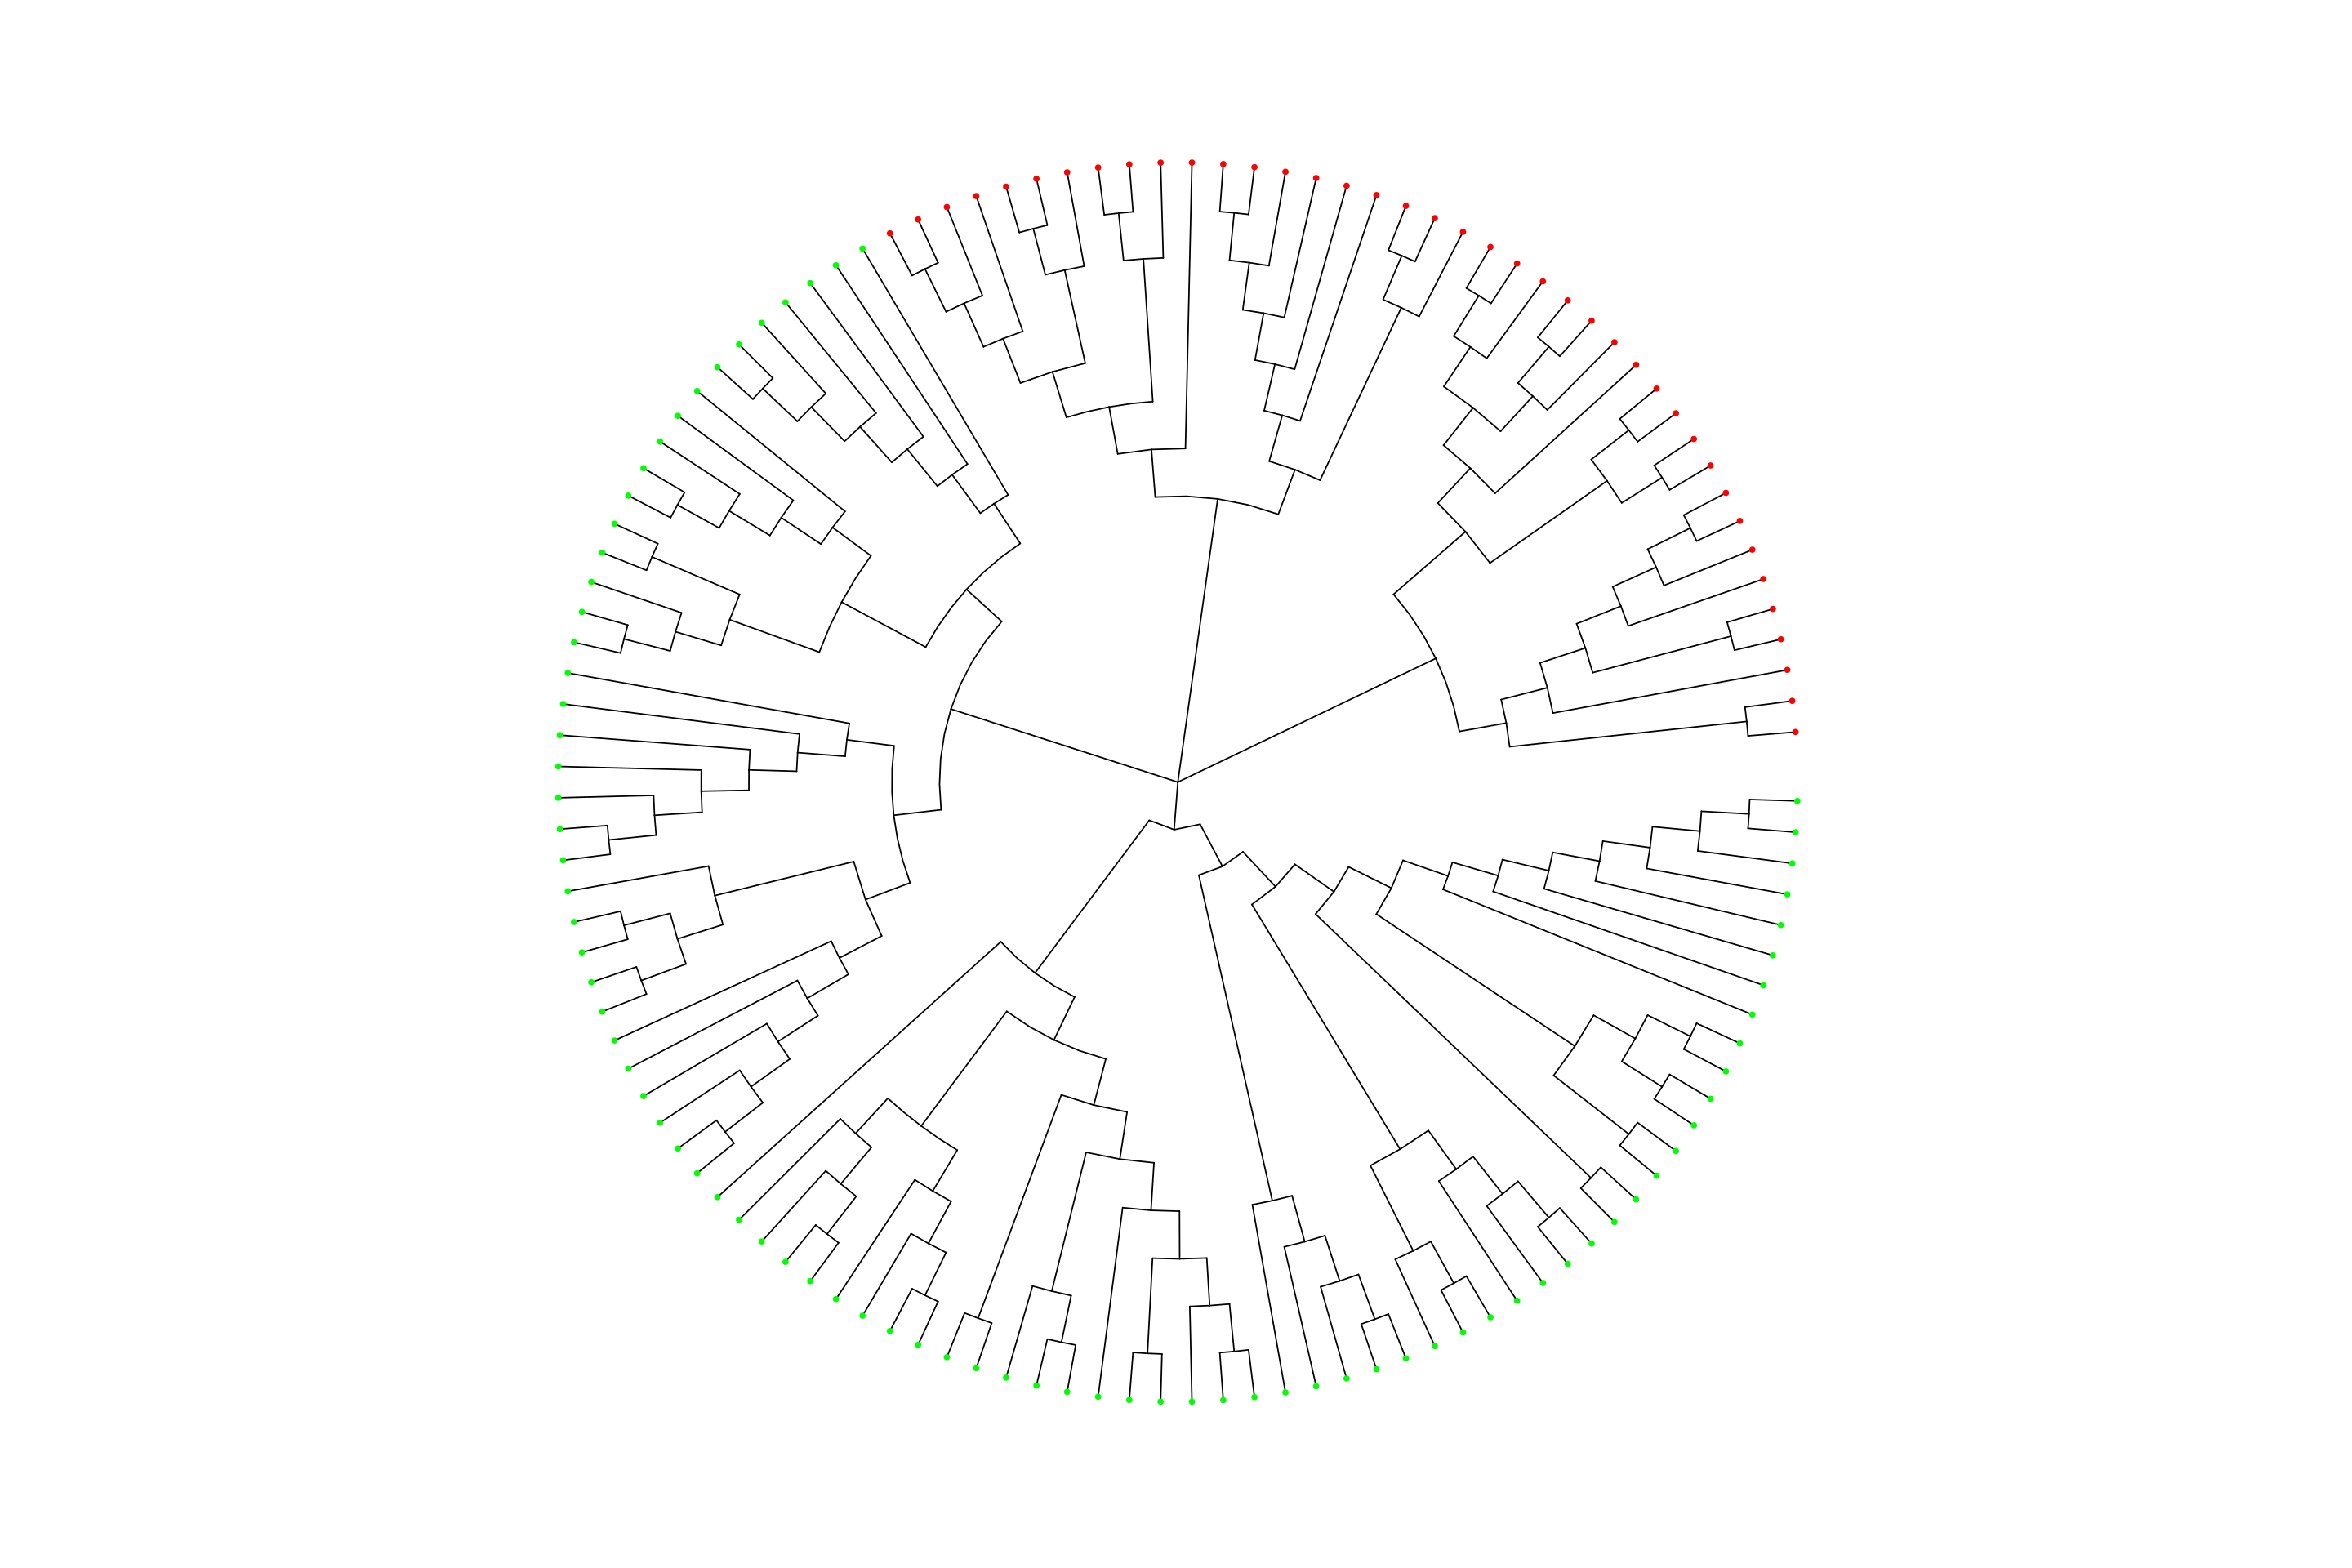

In [2]:
p <- ggtree(combined_tree, branch.length = "none")

tree_data <- p$data

tree_data <- tree_data %>%
  mutate(tip = ifelse(isTip, label, NA))

tree_data <- left_join(tree_data, mortality_df, by = c("tip" = "tube_code"))

tree_data$death_7_day_color <- ifelse(
  tree_data$isTip, ifelse(tree_data$death_7_day == "1", "red", "green"), "black"
)

# Re-plot with colored branches
p <- ggtree(combined_tree, branch.length = "none", layout = "circular") %<+% tree_data +
  geom_tippoint(aes(color = I(death_7_day_color)))

p

Average angle change [1] 0.484163977664723

Average angle change [2] 0.324761274364201

Average angle change [3] 0.292447588791801

Average angle change [4] 0.281741543757629

Average angle change [5] 0.277770956254507



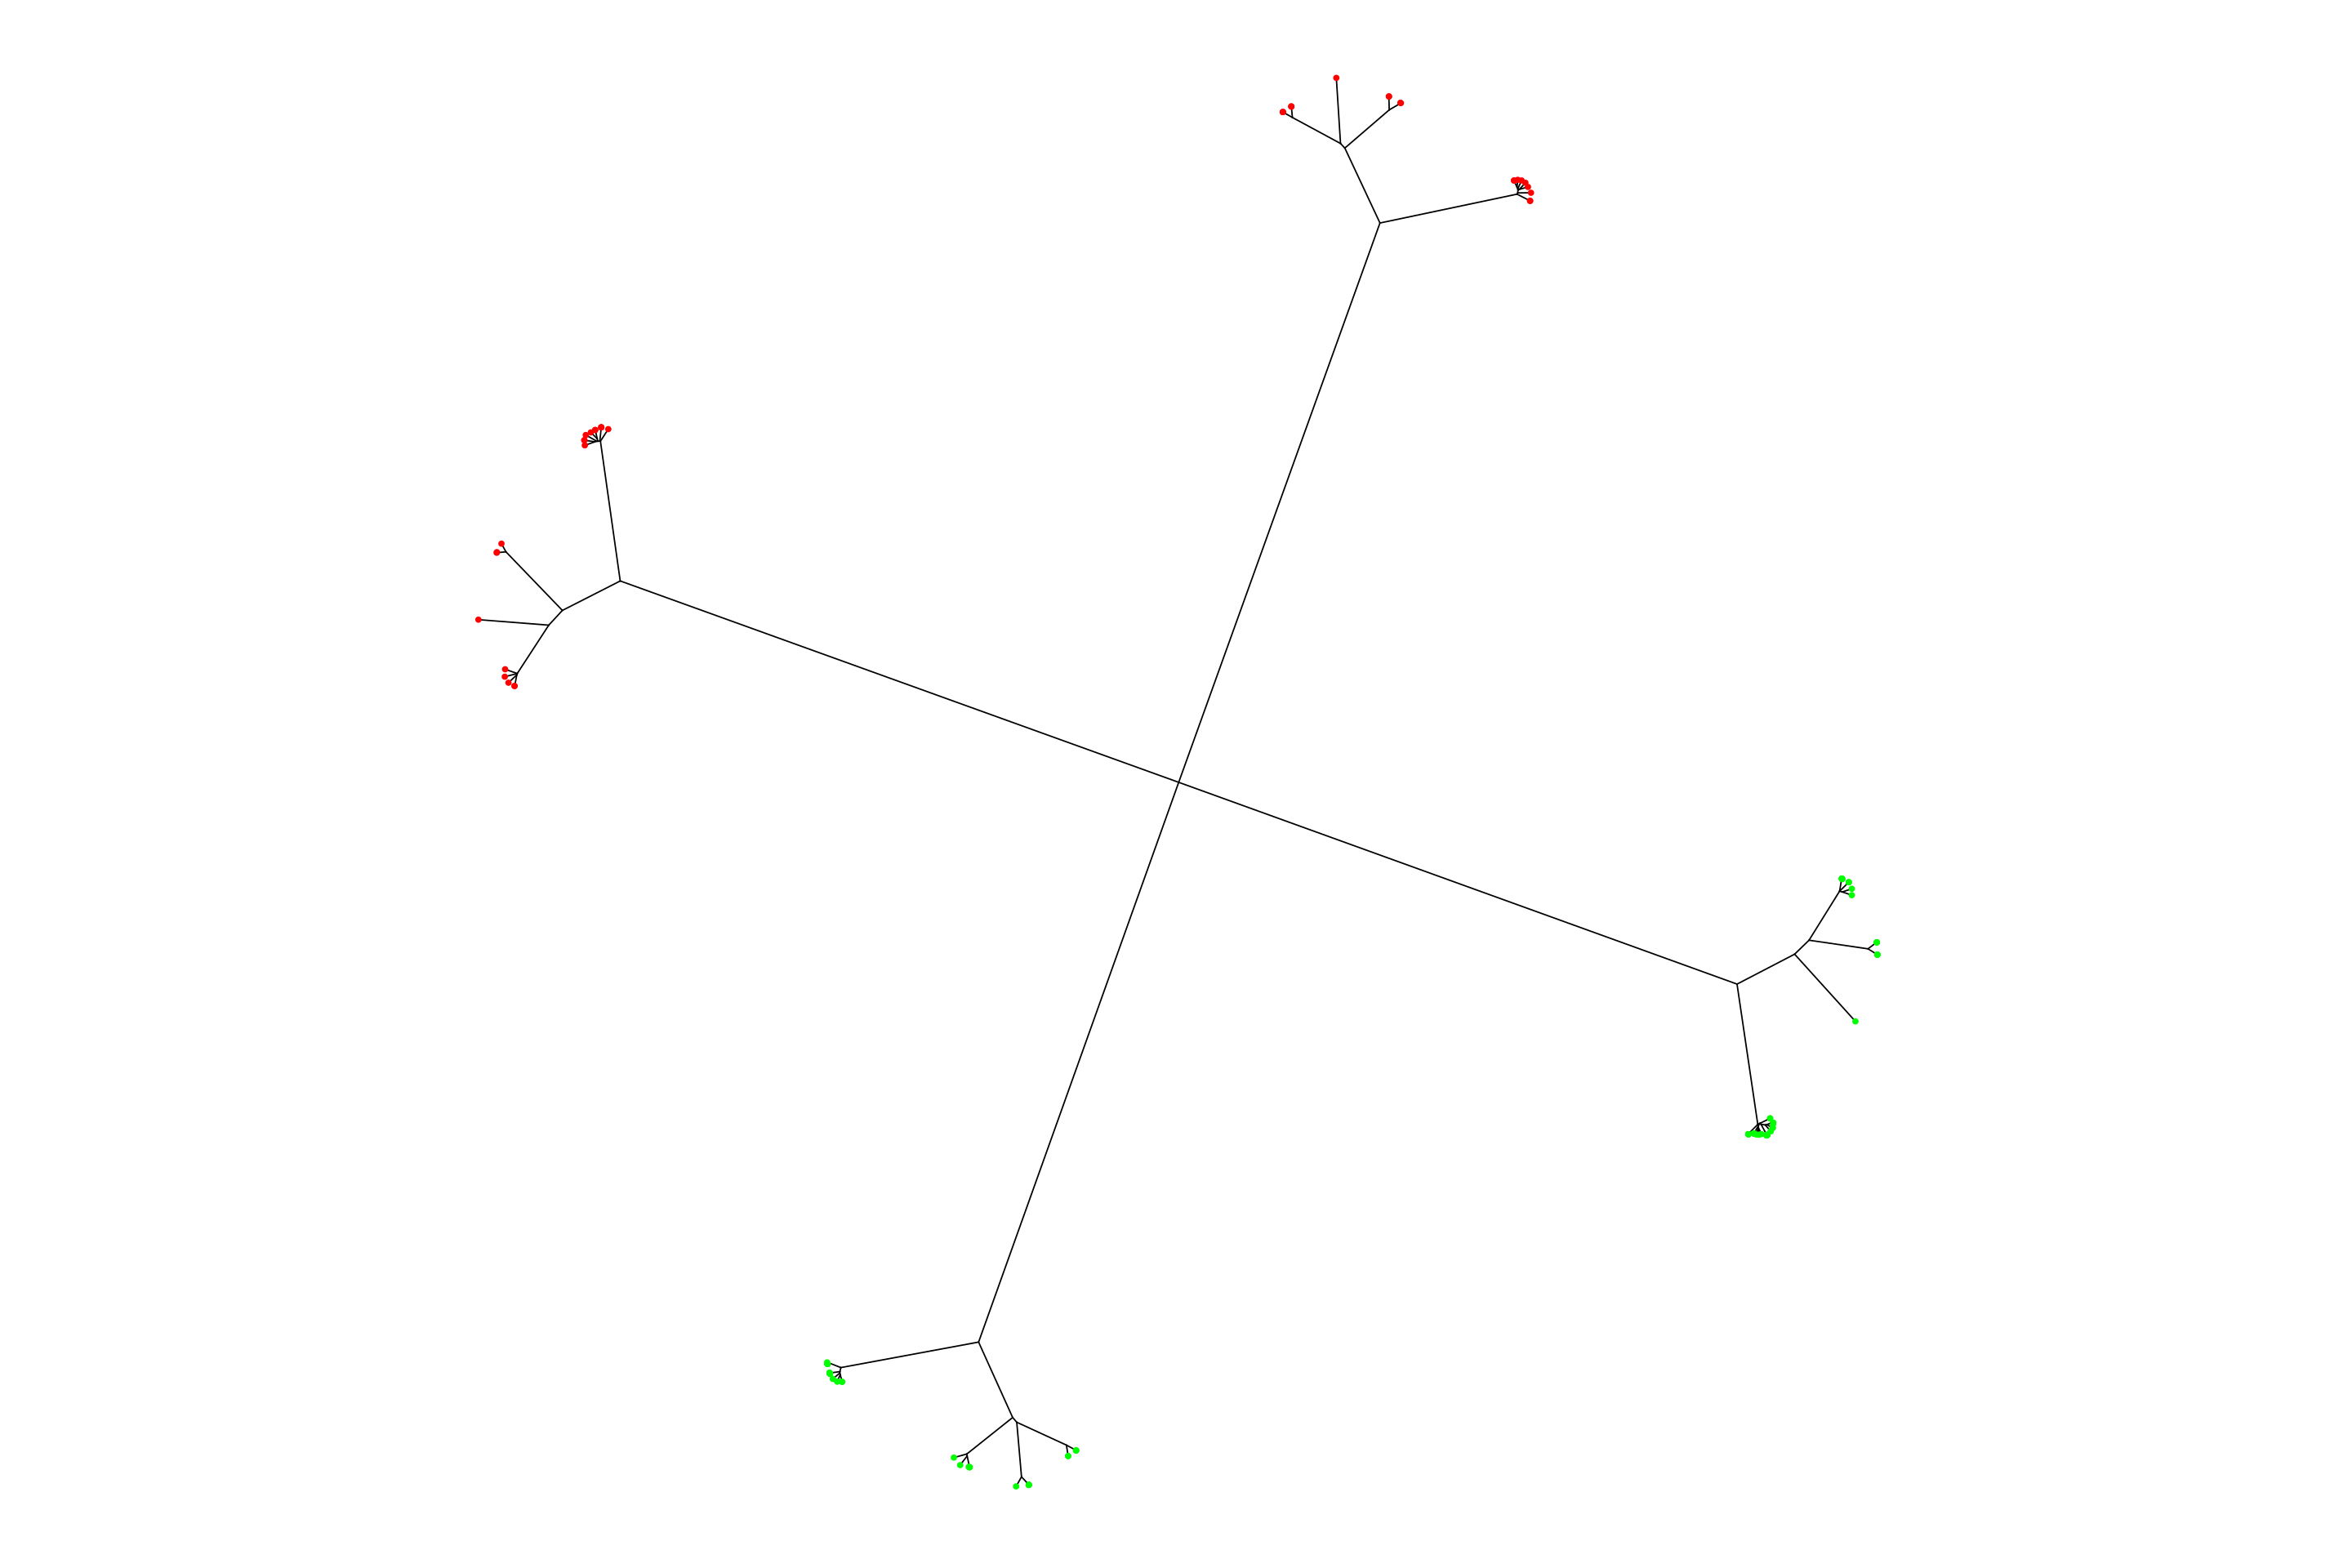

In [3]:
p <- ggtree(combined_tree, branch.length = "none")

tree_data <- p$data

tree_data <- tree_data %>%
  mutate(tip = ifelse(isTip, label, NA))

tree_data <- left_join(tree_data, mortality_df, by = c("tip" = "tube_code"))

tree_data$death_7_day_color <- ifelse(
  tree_data$isTip, ifelse(tree_data$death_7_day == "1", "red", "green"), "black"
)

# Re-plot with colored branches
p <- ggtree(combined_tree, layout = "daylight") %<+% tree_data +
  geom_tippoint(aes(color = I(death_7_day_color)))

p

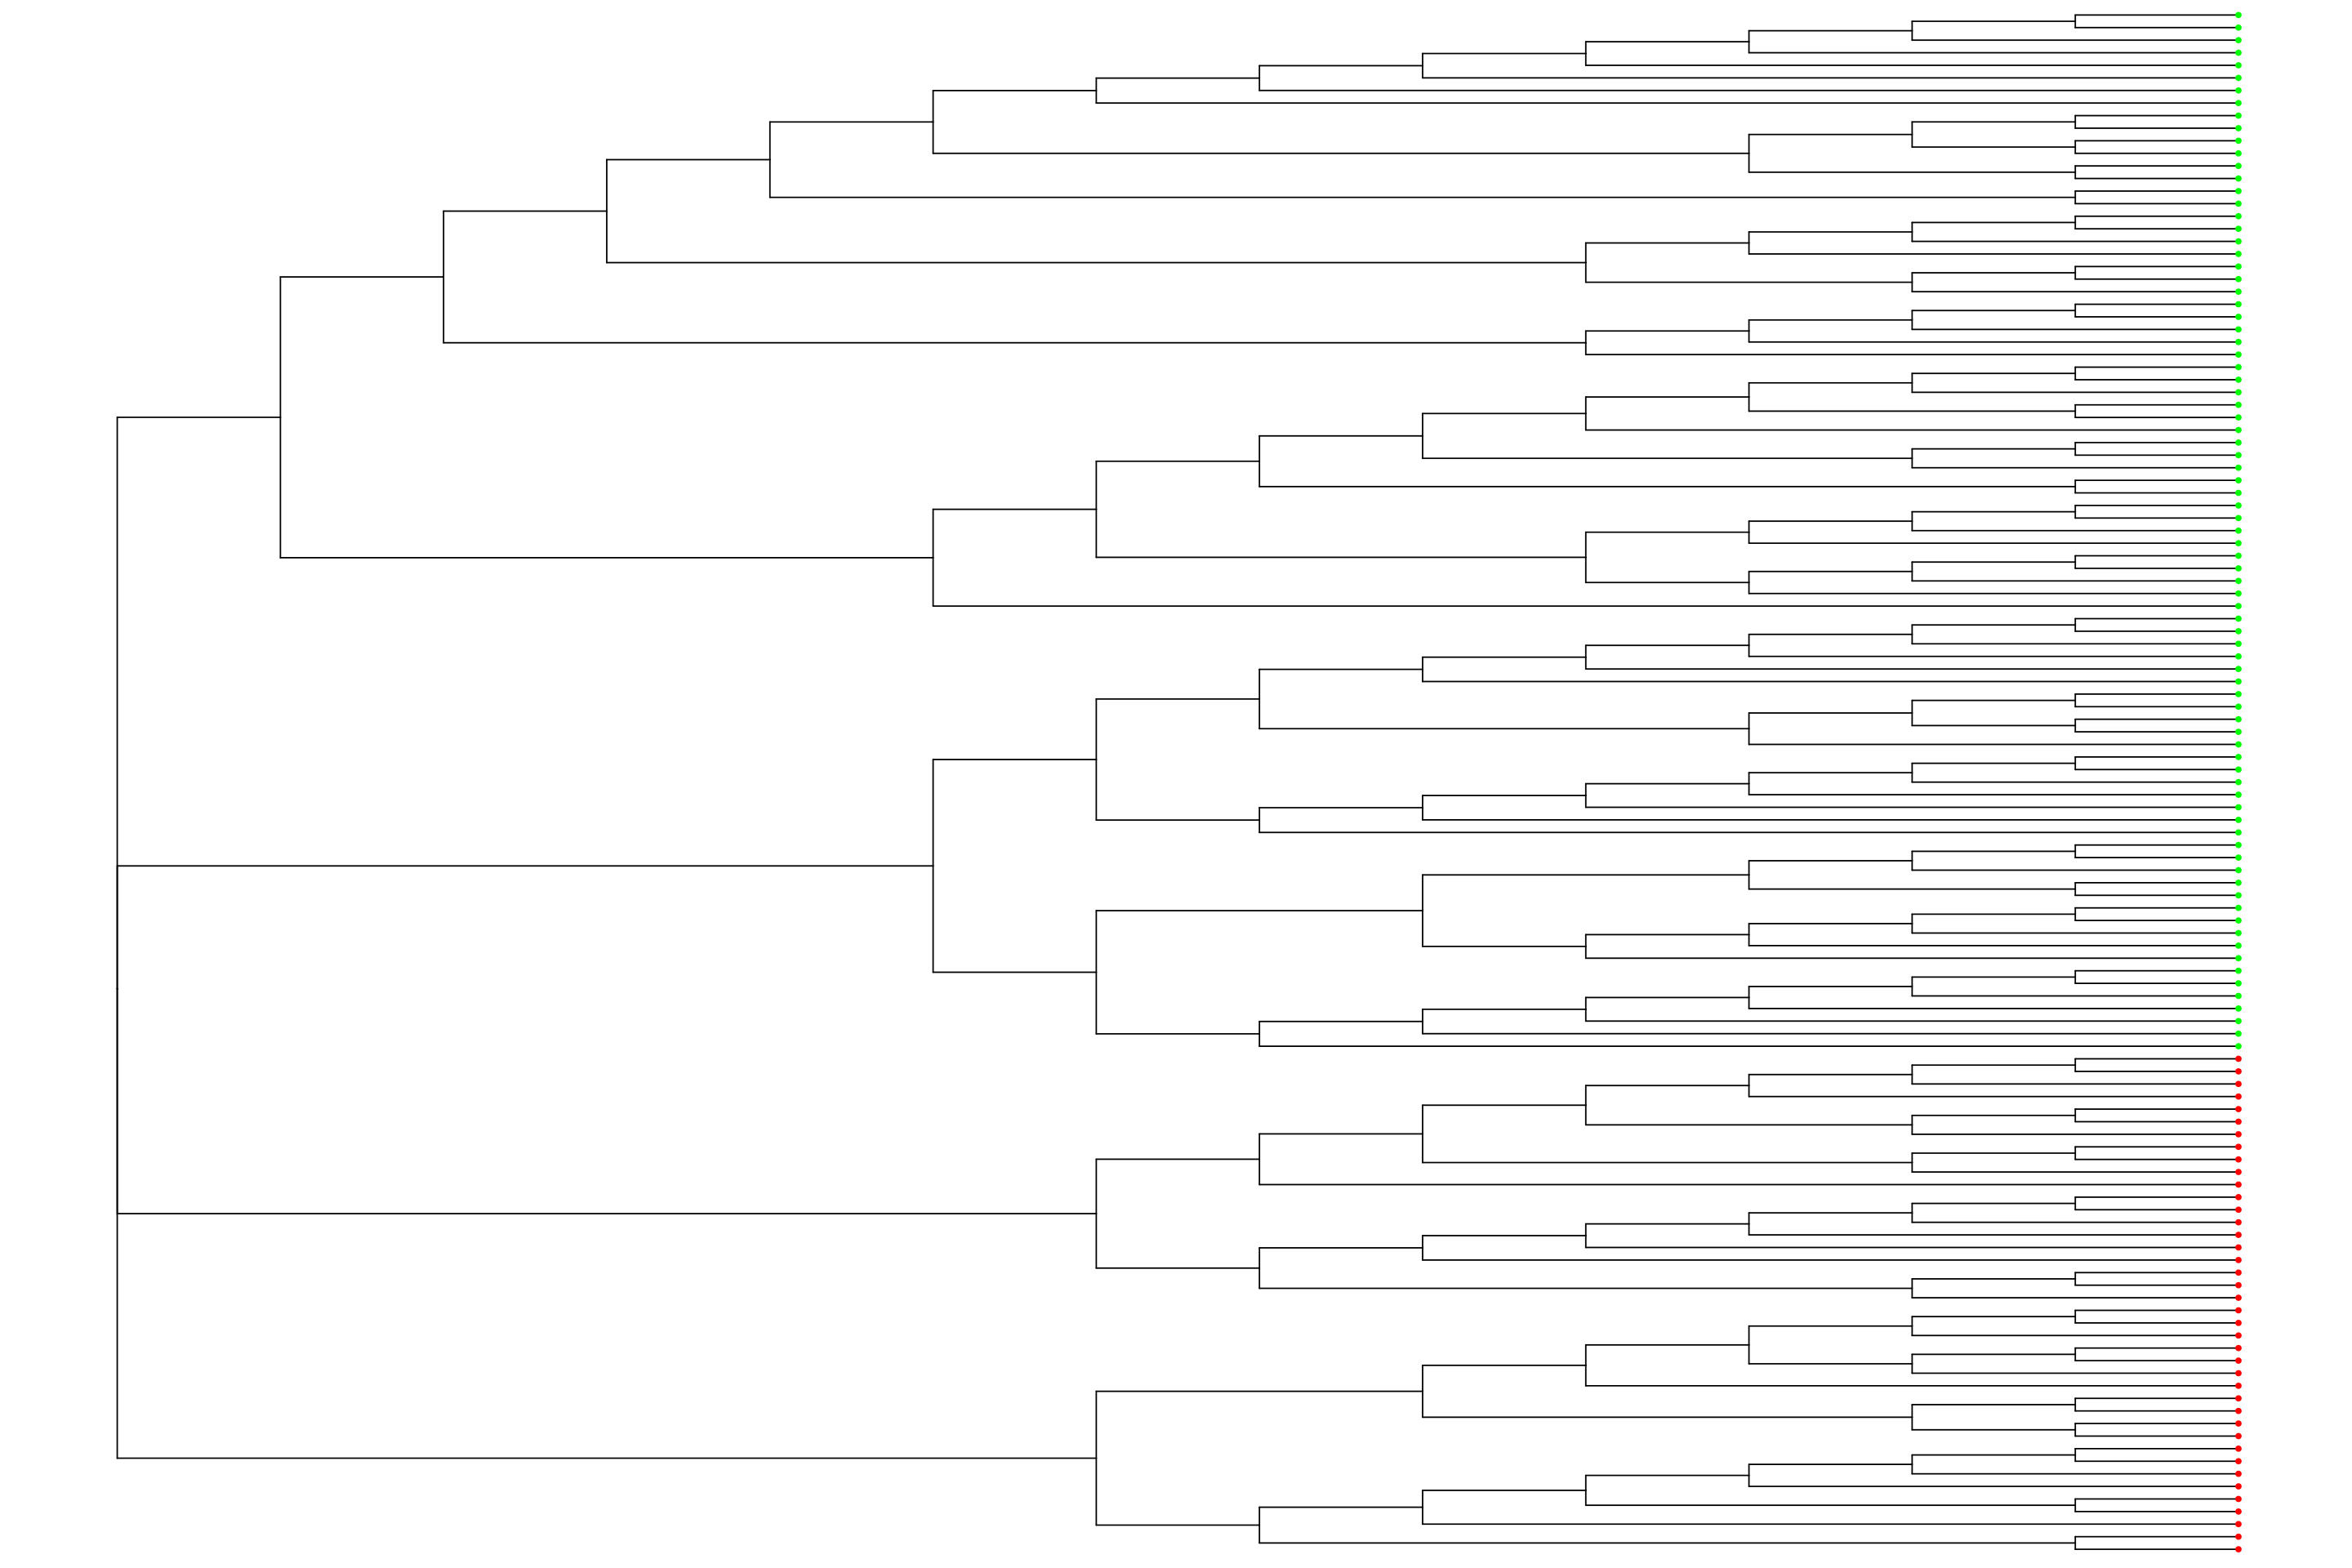

In [4]:
p <- ggtree(combined_tree, branch.length = "none")

tree_data <- p$data

tree_data <- tree_data %>%
  mutate(tip = ifelse(isTip, label, NA))

tree_data <- left_join(tree_data, mortality_df, by = c("tip" = "tube_code"))

tree_data$death_7_day_color <- ifelse(
  tree_data$isTip, ifelse(tree_data$death_7_day == "1", "red", "green"), "black"
)

# Re-plot with colored branches
p <- ggtree(combined_tree, branch.length = "none") %<+% tree_data +
  geom_tippoint(aes(color = I(death_7_day_color)))

p

In [5]:
tip_order <- combined_tree$tip.label

aligned <- readDNAMultipleAlignment(
  filepath = "~/workspace/genome_data/annotations/s_aureus/gene_sequences/essC/sample/aligned.fna",
  format = "fasta"
)

aligned_seqs <- DNAStringSet(aligned)
aligned_ordered <- aligned_seqs[match(tip_order, names(aligned_seqs))]
aligned_ordered_matrix <- as.matrix(aligned_ordered)

conservation <- apply(aligned_ordered_matrix, 2, function(col) {
  max(table(col)) / length(col)
})

# Create data frame
conservation_df <- data.frame(
  position = 1:length(conservation),
  conservation = conservation
)

conservation_df <- conservation_df %>%
  mutate(variability = 1 - conservation)

aligned_ordered_msa <- DNAMultipleAlignment(aligned_ordered)

In [6]:
library(pbapply)
pboptions(type = "timer")

data <- read.csv(
  "~/workspace/ehr_data/data/full_cohort/high_score_tokens.csv",
  header = FALSE
)
all_coordinates <- pbapply(data, 1, function(row) {
  # process each row (as a vector)
  motif <- row[[1]]

  matches <- lapply(aligned_ordered, function(seq) {
    pos <- gregexpr(motif, seq)[[1]]
    if (pos[1] != -1) unique(pos) else NA
  })
  all_positions <- unlist(matches)
  unique_positions <- unique(
    all_positions[!is.na(all_positions)]
  )
  lapply(unique_positions, function(pos) {
    c(pos, pos + nchar(motif), motif)
  })

})

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=15m 49s


In [ ]:
library(patchwork)


for (i in seq(from = 1, to = 4700, by = 200)) {

  print("---------------------------------------------")
  print(paste0("-------------", i, "-------------------------"))
  print("---------------------------------------------")
  start <- i
  end <- (i - 1) + 200

  msa_plot <- 'msa_plot <- ggmsa(
    aligned_ordered_msa,
    start = %d,
    end = %d,
    color = "Chemistry_NT"
  )'

  rect_annotation <- 'annotate(
  "rect",
  xmin = %s,
  xmax = %s,
  ymin = -Inf,
  ymax = Inf,
  alpha = 0.1,
  fill = "red"
  )'

  text_annotation <- 'annotate(
    "text",
    x = %d,
    y = -1,
    label = "%s",
    color = "black",
    size = 3
  )'

  eval(parse(text = sprintf(msa_plot, start, end)))

  unpacked_coordinates <- do.call(c, all_coordinates)

  plot_coordinates <- Filter(function(coord) {
    ((as.integer(coord[1]) >= start) && (as.integer(coord[2]) <= end))
  }, unpacked_coordinates)

  for (coordinate in plot_coordinates) {
    rect_code <- sprintf(rect_annotation, coordinate[1], coordinate[2])
    msa_plot <- msa_plot + eval(parse(text = rect_code))

    text_x <- round((as.integer(coordinate[1]) + as.integer(coordinate[2])) / 2)
    text_code <- sprintf(text_annotation, text_x, coordinate[3])
    msa_plot <- msa_plot + eval(parse(text = text_code))
  }

  conservation_plot <- ggplot(
    conservation_df[start: end, ],
    aes(x = position, y = conservation)
  ) +
    geom_col() +
    coord_fixed(ratio = 13.2) +
    theme_minimal()

  final_plot <- msa_plot / conservation_plot + plot_layout(heights = c(10, 1))

  ggsave(
    paste0(
      "~/workspace/genome_data/annotations/s_aureus/msa_plots/essC_sample/sorted/msa_tokens_plot_",
      start,
      "_",
      end,
      ".png"
    ),
    plot = final_plot,
    dpi = 600,
    width = 24,
    height = 16,
    units = "in"
  )
}

[1] "---------------------------------------------"
[1] "-------------1-------------------------"
[1] "---------------------------------------------"


Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


[1] "---------------------------------------------"
[1] "-------------201-------------------------"
[1] "---------------------------------------------"


Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


[1] "---------------------------------------------"
[1] "-------------401-------------------------"
[1] "---------------------------------------------"


Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


[1] "---------------------------------------------"
[1] "-------------601-------------------------"
[1] "---------------------------------------------"


Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


[1] "---------------------------------------------"
[1] "-------------801-------------------------"
[1] "---------------------------------------------"


Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


[1] "---------------------------------------------"
[1] "-------------1001-------------------------"
[1] "---------------------------------------------"


Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


[1] "---------------------------------------------"
[1] "-------------1201-------------------------"
[1] "---------------------------------------------"


Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


[1] "---------------------------------------------"
[1] "-------------1401-------------------------"
[1] "---------------------------------------------"


Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


[1] "---------------------------------------------"
[1] "-------------1601-------------------------"
[1] "---------------------------------------------"


Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


[1] "---------------------------------------------"
[1] "-------------1801-------------------------"
[1] "---------------------------------------------"


Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”
